##  Import Libraries

In [ ]:
## pip install pandas numpy matplotlib seaborn scikit-learn gensim tensorflow-gpu==2.10.0

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import gensim.downloader as api

##  Load and Explore Dataset


In [4]:
# Read the CSV file
data = pd.read_csv('assignment3_data.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
print(data.head())

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# Dataset info
print("\nDataset info:")
print(data.info())

# Check unique sentiment values
print("\nUnique sentiment values:")
print(data['Sentiment'].value_counts())

First 5 rows of the dataset:
                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral

Missing values per column:
Sentence     0
Sentiment    0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None

Unique sentiment values:
neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


##  Step 1: Pre-processing
1.1: Handling numerical values

In [5]:
def convert_numbers(text):
    """
    Convert all numerical values to digits 1-9
    """
    if not isinstance(text, str):
        return text
        
    # Find numerical patterns (integers and decimals)
    def replace_match(match):
        # Get the numerical value
        num = float(match.group(0))
        # Map to a single digit 1-9 (using modulo to keep it simple)
        if num != 0:
            return str(1 + (int(abs(num)) % 9))
        else:
            return '1'  # Map zero to 1
    
    # Regular expression to find all numbers (including decimals)
    pattern = r'\d+\.\d+|\d+'
    return re.sub(pattern, replace_match, text)

# Test the function
test_sentence = "The company raised $5.6 M and another EUR2.5b in funding so profits increased by 15%."
print("Original:", test_sentence)
print("Converted:", convert_numbers(test_sentence))

Original: The company raised $5.6 M and another EUR2.5b in funding so profits increased by 15%.
Converted: The company raised $6 M and another EUR3b in funding so profits increased by 7%.


##  1.2: Handling financial terms and linguistics

In [6]:
def convert_financial_terms(text):
    """
    Convert financial notations like 'k', 'm', 'b', 't' to 'thousand', 'million', 'billion', 'trillion'
    and reformat monetary units
    """
    if not isinstance(text, str):
        return text
        
    # First pattern: Currency codes followed by numbers and optional magnitude
    # Example: USD7m, EUR1b, CAD 2T
    pattern1 = r'([A-Z]{3})\s*(\d+)([kKmMbBtT]?)'
    
    def process_monetary(match):
        currency = match.group(1)
        number = match.group(2)
        magnitude = match.group(3).lower() if match.group(3) else ""
        
        # Convert magnitude abbreviations
        if magnitude == 'k':
            magnitude = ' thousand'
        elif magnitude == 'm':
            magnitude = ' million'
        elif magnitude == 'b':
            magnitude = ' billion'
        elif magnitude == 't':
            magnitude = ' trillion'
        else:
            magnitude = ''
        
        # Format as "number magnitude currency"
        return f"{number}{magnitude} {currency}"
    
    # Apply first transformation
    processed_text = re.sub(pattern1, process_monetary, text)
    
    # Second pattern: dollar sign followed by numbers and optional magnitude
    # Example: $5m, $2k
    pattern2 = r'(\$)\s*(\d+)([kKmMbBtT]?)'
    
    def process_dollar(match):
        number = match.group(2)
        magnitude = match.group(3).lower() if match.group(3) else ""
        
        # Convert magnitude abbreviations
        if magnitude == 'k':
            magnitude = ' thousand'
        elif magnitude == 'm':
            magnitude = ' million'
        elif magnitude == 'b':
            magnitude = ' billion'
        elif magnitude == 't':
            magnitude = ' trillion'
        else:
            magnitude = ''
        
        # Format as "number magnitude USD"
        return f"{number}{magnitude} USD"
    
    # Apply second transformation
    processed_text = re.sub(pattern2, process_dollar, processed_text)
    
    # Third pattern: standalone magnitude indicators after numbers
    # Example: 7k users, 3m customers
    pattern3 = r'(\d+)([kKmMbBtT])\b'
    
    def expand_magnitude(match):
        num = match.group(1)
        mag = match.group(2).lower()
        
        if mag == 'k':
            return f"{num} thousand"
        elif mag == 'm':
            return f"{num} million"
        elif mag == 'b':
            return f"{num} billion"
        elif mag == 't':
            return f"{num} trillion"
    
    # Apply third transformation
    return re.sub(pattern3, expand_magnitude, processed_text)

# Test the function
test_cases = ['USD7m', 'EUR1b', 'CAD 2T', '$5m profit', '3k users']
print("Financial terms conversion examples:")
for test in test_cases:
    print(f"Original: {test}")
    print(f"Converted: {convert_financial_terms(test)}")

Financial terms conversion examples:
Original: USD7m
Converted: 7 million USD
Original: EUR1b
Converted: 1 billion EUR
Original: CAD 2T
Converted: 2 trillion CAD
Original: $5m profit
Converted: 5 million USD profit
Original: 3k users
Converted: 3 thousand users


## 1.3: Remove all punctuations and special characters

In [7]:
def remove_punctuation(text):
    """
    Remove all punctuation and special characters
    """
    if not isinstance(text, str):
        return text
        
    return re.sub(r'[^\w\s]', '', text)

# Test the function
test_sentence = "The company's profit margin increased to 15.2%, exceeding expectations!"
print("\nPunctuation removal example:")
print("Original:", test_sentence)
print("Cleaned:", remove_punctuation(test_sentence))


Punctuation removal example:
Original: The company's profit margin increased to 15.2%, exceeding expectations!
Cleaned: The companys profit margin increased to 152 exceeding expectations


## 1.4: Remove extra spaces

In [8]:
def remove_extra_spaces(text):
    """
    Remove extra spaces in text
    """
    if not isinstance(text, str):
        return text
        
    return re.sub(r'\s+', ' ', text).strip()

# Test the function
test_sentence = "The  company   reported   strong  results."
print("\nExtra spaces removal example:")
print("Original:", test_sentence)
print("Cleaned:", remove_extra_spaces(test_sentence))


Extra spaces removal example:
Original: The  company   reported   strong  results.
Cleaned: The company reported strong results.


## 1.5: all preprocessing steps to the dataset


In [9]:
def preprocess_text(text):
    """
    Apply all preprocessing steps
    """
    # Step 1: Convert numbers
    text = convert_numbers(text)
    
    # Step 2: Handle financial terms
    text = convert_financial_terms(text)
    
    # Step 3: Remove punctuation
    text = remove_punctuation(text)
    
    # Step 4: Remove extra spaces
    text = remove_extra_spaces(text)
    
    return text

# Apply preprocessing to the dataset
data['Processed_Sentence'] = data['Sentence'].apply(preprocess_text)

# Display a few processed examples
print("\nOriginal vs Processed Examples:")
for i in range(5):
    print(f"\nOriginal: {data['Sentence'].iloc[i]}")
    print(f"Processed: {data['Processed_Sentence'].iloc[i]}")


Original vs Processed Examples:

Original: The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
Processed: The GeoSolutions technology will leverage Benefon s GPS solutions by providing Location Based Search Technology a Communities Platform location relevant multimedia content and a new and powerful commercial model

Original: $ESI on lows, down $1.50 to $2.50 BK a real possibility
Processed: ESI on lows down 2 USD to 3 USD BK a real possibility

Original: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Processed: For the last quarter of 4 Componenta s net sales doubled to 6 million EUR from 5 million EUR for the same period a year earlier while it moved to a zero pretax profit

## Step 2: Creating an embedding matrix
2.1: Load Word2Vec model and create vocabulary

In [10]:
# Load pre-trained Word2Vec model
print("\nLoading Word2Vec model...")
word2vec_model = api.load('word2vec-google-news-300')
print("Word2Vec model loaded successfully.")

# Check the model's vocabulary size
vocab_size_w2v = len(word2vec_model.key_to_index)
embedding_dim = word2vec_model.vector_size
print(f"Word2Vec vocabulary size: {vocab_size_w2v}")
print(f"Word2Vec embedding dimension: {embedding_dim}")

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Processed_Sentence'])

# Create filtered vocabulary with only words in Word2Vec
vocabulary = {'</s>': 0}  # Start with sentence separator token
word_idx = 1

for word, idx in tokenizer.word_index.items():
    if word in word2vec_model.key_to_index:
        vocabulary[word] = word_idx
        word_idx += 1

print(f"\nTotal tokens in filtered vocabulary: {len(vocabulary)}")
print(f"First 10 tokens: {list(vocabulary.items())[:10]}")


Loading Word2Vec model...
Word2Vec model loaded successfully.
Word2Vec vocabulary size: 3000000
Word2Vec embedding dimension: 300

Total tokens in filtered vocabulary: 7761
First 10 tokens: [('</s>', 0), ('the', 1), ('in', 2), ('eur', 3), ('for', 4), ('2', 5), ('1', 6), ('3', 7), ('s', 8), ('from', 9)]


##  2.2: Create embedding matrix

In [11]:
# Create embedding matrix
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))

# Fill the embedding matrix with Word2Vec vectors
for word, idx in vocabulary.items():
    if idx > 0 and word in word2vec_model.key_to_index:
        embedding_matrix[idx] = word2vec_model[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (7761, 300)


## 2.3 Convert sentences to embedding indices

In [12]:
def texts_to_sequences(texts, vocab):
    """
    Convert texts to sequences of embedding indices
    """
    sequences = []
    for text in texts:
        seq = []
        for word in text.split():
            if word in vocab:
                seq.append(vocab[word])
        sequences.append(seq)
    return sequences

# Convert texts to sequences
sequences = texts_to_sequences(data['Processed_Sentence'], vocabulary)

# Find the maximum sequence length
max_seq_length = max([len(seq) for seq in sequences])
# Add a buffer of 2 tokens as required
max_length = max_seq_length + 2

print(f"\nMaximum sequence length: {max_length}")

# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

print(f"Shape of padded sequences: {padded_sequences.shape}")


Maximum sequence length: 47
Shape of padded sequences: (5842, 47)


## 2.4:  Convert labels to one-hot vectors

In [13]:
# Map sentiment labels to numeric values
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['sentiment_id'] = data['Sentiment'].map(sentiment_mapping)

# Convert to one-hot vectors
y = to_categorical(data['sentiment_id'])

print(f"\nShape of target variable: {y.shape}")
print(f"First 5 encoded labels: {y[:5]}")


Shape of target variable: (5842, 3)
First 5 encoded labels: [[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


## Step 3: Neural Networks
 Check for class imbalance

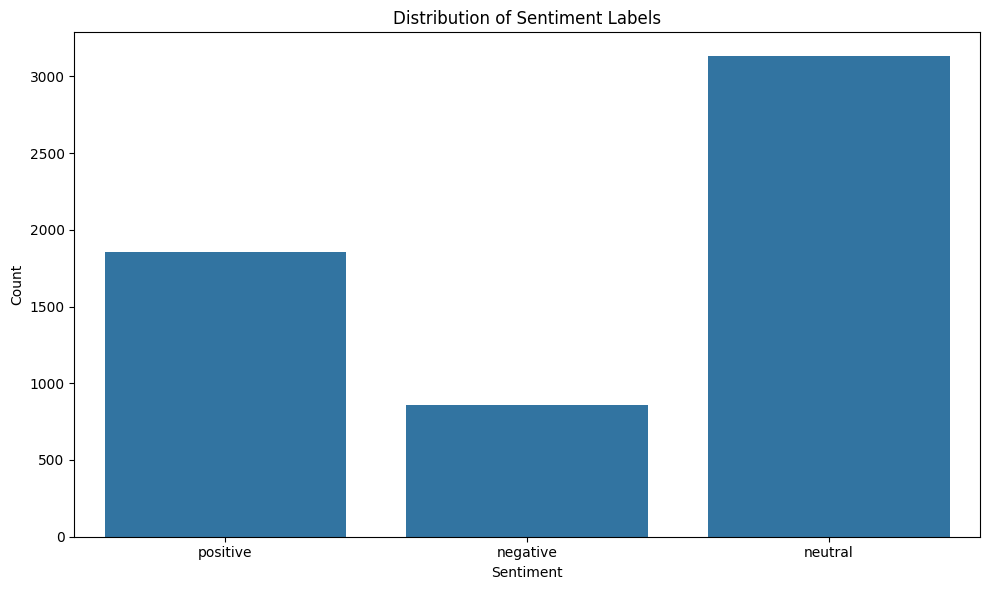


Class distribution:
neutral: 3130 samples (53.58%)
positive: 1852 samples (31.70%)
negative: 860 samples (14.72%)

Calculated class weights:
Class 0: 2.2643
Class 1: 0.6222
Class 2: 1.0515


In [14]:
# Plot distribution of sentiment labels
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=data)
plt.title('Distribution of Sentiment Labels')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

# Print count and percentage for each class
sentiment_counts = data['Sentiment'].value_counts()
print("\nClass distribution:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count} samples ({count/len(data)*100:.2f}%)")

# Calculate class weights based on the distribution
class_weights = {
    0: len(data) / (3 * (data['sentiment_id'] == 0).sum()),
    1: len(data) / (3 * (data['sentiment_id'] == 1).sum()),
    2: len(data) / (3 * (data['sentiment_id'] == 2).sum())
}
print("\nCalculated class weights:")
for class_id, weight in class_weights.items():
    print(f"Class {class_id}: {weight:.4f}")

## Split data into training and testing sets

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (4673, 47)
Testing set shape: (1169, 47)


## 3.1- FFN Classifier with pre-trained embeddings


Model 1: FFN with frozen embeddings
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 300)           2328300   
                                                                 
 flatten (Flatten)           (None, 14100)             0         
                                                                 
 dense (Dense)               (None, 128)               1804928   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)   

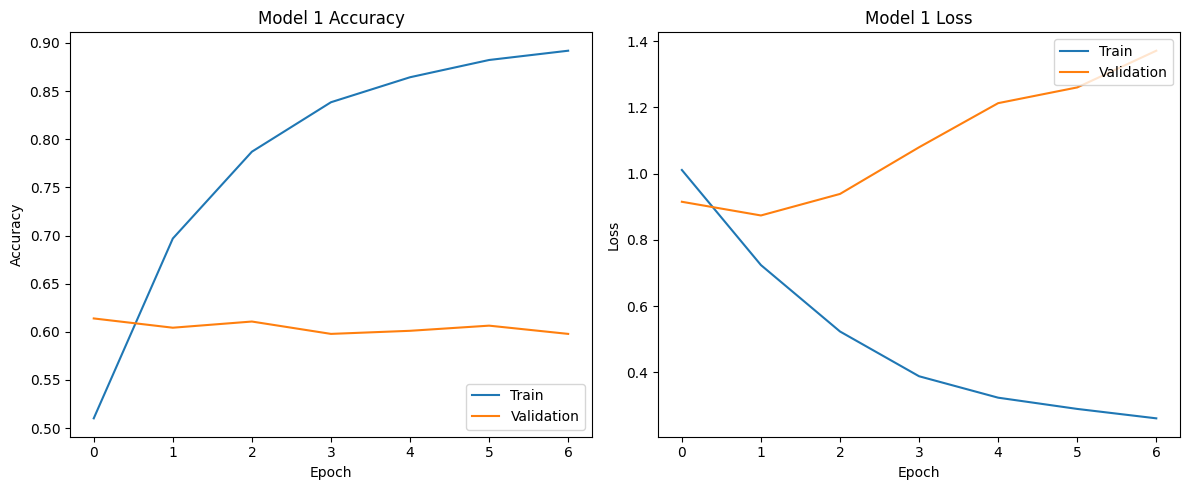

37/37 [==============================] - 0s 1ms/step - loss: 0.8524 - accuracy: 0.6228

Model 1 Test Loss: 0.8524
Model 1 Test Accuracy: 0.6228
37/37 [==============================] - 0s 583us/step

Classification Report (Model 1 - FFN with frozen embeddings):
              precision    recall  f1-score   support

    negative       0.33      0.49      0.40       175
     neutral       0.74      0.71      0.73       622
    positive       0.63      0.54      0.58       372

    accuracy                           0.62      1169
   macro avg       0.57      0.58      0.57      1169
weighted avg       0.65      0.62      0.63      1169



In [16]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Build the FFN model with frozen embeddings
model1 = Sequential([
    # Embedding layer with pre-trained weights (non-trainable)
    Embedding(
        input_dim=len(vocabulary),
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=False
    ),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("\nModel 1: FFN with frozen embeddings")
model1.summary()

# Train the model
history1 = model1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('model1_history.png')
plt.show()

# Evaluate the model
loss1, accuracy1 = model1.evaluate(X_test, y_test)
print(f"\nModel 1 Test Loss: {loss1:.4f}")
print(f"Model 1 Test Accuracy: {accuracy1:.4f}")

# Get predictions and classification report
y_pred_prob1 = model1.predict(X_test)
y_pred1 = np.argmax(y_pred_prob1, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report (Model 1 - FFN with frozen embeddings):")
print(classification_report(y_true, y_pred1, target_names=['negative', 'neutral', 'positive']))

## 3.2- FFN Classifier with fine-tuning pre-trained embeddings


Model 2: FFN with trainable embeddings
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 47, 300)           2328300   
                                                                 
 flatten_1 (Flatten)         (None, 14100)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               1804928   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dens

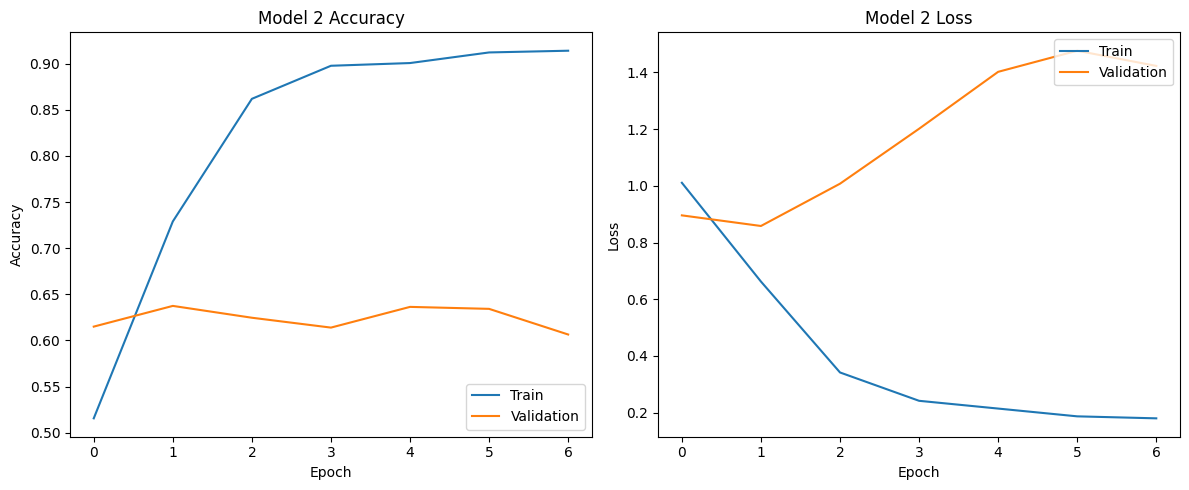

37/37 [==============================] - 0s 1ms/step - loss: 0.8174 - accuracy: 0.6587

Model 2 Test Loss: 0.8174
Model 2 Test Accuracy: 0.6587
37/37 [==============================] - 0s 611us/step

Classification Report (Model 2 - FFN with trainable embeddings):
              precision    recall  f1-score   support

    negative       0.36      0.51      0.42       175
     neutral       0.77      0.72      0.74       622
    positive       0.69      0.63      0.66       372

    accuracy                           0.66      1169
   macro avg       0.61      0.62      0.61      1169
weighted avg       0.68      0.66      0.67      1169



In [18]:
# Define Model 2: FFN with trainable embeddings
model2 = Sequential([
    # Embedding layer with pre-trained weights (trainable)
    Embedding(
        input_dim=len(vocabulary),
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=True
    ),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("\nModel 2: FFN with trainable embeddings")
model2.summary()

# Train the model
history2 = model2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('model2_history.png')
plt.show()

# Evaluate the model
loss2, accuracy2 = model2.evaluate(X_test, y_test)
print(f"\nModel 2 Test Loss: {loss2:.4f}")
print(f"Model 2 Test Accuracy: {accuracy2:.4f}")

# Get predictions and classification report
y_pred_prob2 = model2.predict(X_test)
y_pred2 = np.argmax(y_pred_prob2, axis=1)

# Print classification report
print("\nClassification Report (Model 2 - FFN with trainable embeddings):")
print(classification_report(y_true, y_pred2, target_names=['negative', 'neutral', 'positive']))

## 3.3- RNN with FFN Classifier head and using pre-trained embeddings


Model 3: RNN with FFN Classifier head
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 47, 300)           2328300   
                                                                 
 simple_rnn (SimpleRNN)      (None, 47, 128)           54912     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dro

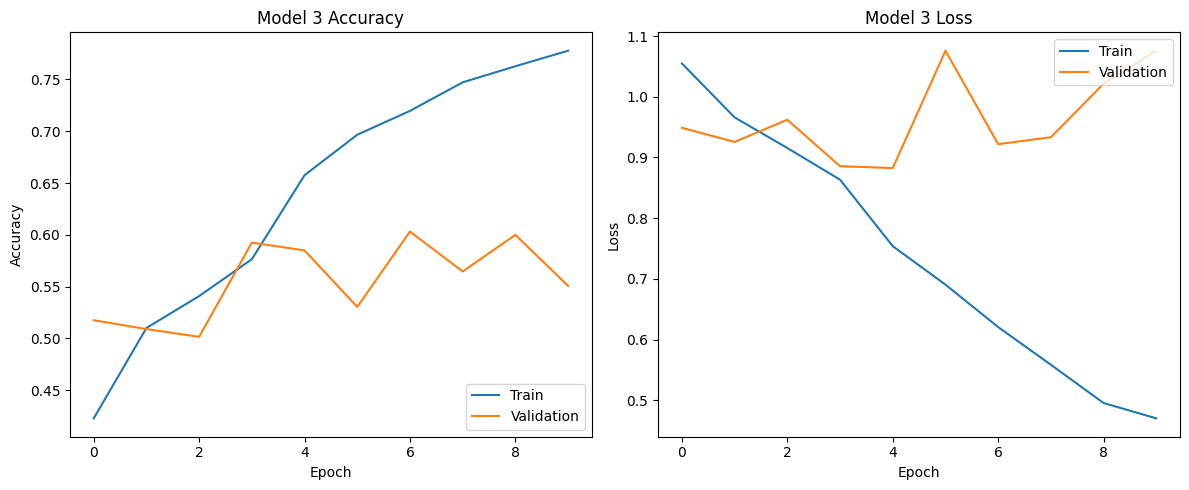

37/37 [==============================] - 0s 7ms/step - loss: 0.8711 - accuracy: 0.5672

Model 3 Test Loss: 0.8711
Model 3 Test Accuracy: 0.5672
37/37 [==============================] - 0s 7ms/step

Classification Report (Model 3 - RNN with FFN Classifier head):
              precision    recall  f1-score   support

    negative       0.31      0.55      0.40       175
     neutral       0.79      0.57      0.66       622
    positive       0.52      0.57      0.54       372

    accuracy                           0.57      1169
   macro avg       0.54      0.56      0.53      1169
weighted avg       0.63      0.57      0.58      1169



In [19]:
# Build RNN model with FFN classifier head
model3 = Sequential([
    # Embedding layer with pre-trained weights (non-trainable)
    Embedding(
        input_dim=len(vocabulary),
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=False
    ),
    # Stacked RNNs
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(64),
    # FFN classifier head
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("\nModel 3: RNN with FFN Classifier head")
model3.summary()

# Train the model
history3 = model3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('model3_history.png')
plt.show()

# Evaluate the model
loss3, accuracy3 = model3.evaluate(X_test, y_test)
print(f"\nModel 3 Test Loss: {loss3:.4f}")
print(f"Model 3 Test Accuracy: {accuracy3:.4f}")

# Get predictions and classification report
y_pred_prob3 = model3.predict(X_test)
y_pred3 = np.argmax(y_pred_prob3, axis=1)

# Print classification report
print("\nClassification Report (Model 3 - RNN with FFN Classifier head):")
print(classification_report(y_true, y_pred3, target_names=['negative', 'neutral', 'positive']))

## 3.4- Complex RNN with FFN Classifier head using pre-trained embeddings



Model 4: Bidirectional RNN with FFN Classifier head
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 47, 300)           2328300   
                                                                 
 bidirectional (Bidirectiona  (None, 47, 256)          109824    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              41088     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 

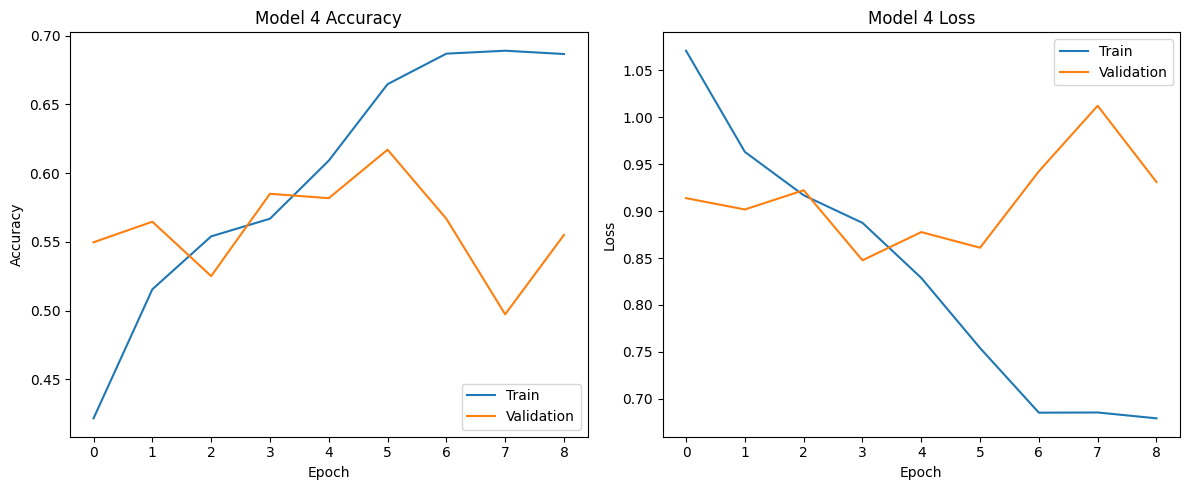

37/37 [==============================] - 0s 13ms/step - loss: 0.8348 - accuracy: 0.6005

Model 4 Test Loss: 0.8348
Model 4 Test Accuracy: 0.6005
37/37 [==============================] - 1s 13ms/step

Classification Report (Model 4 - Bidirectional RNN with FFN Classifier head):
              precision    recall  f1-score   support

    negative       0.32      0.66      0.43       175
     neutral       0.78      0.69      0.73       622
    positive       0.63      0.42      0.50       372

    accuracy                           0.60      1169
   macro avg       0.57      0.59      0.55      1169
weighted avg       0.66      0.60      0.61      1169



In [20]:
# Build bidirectional RNN model with FFN classifier head
model4 = Sequential([
    # Embedding layer with pre-trained weights (non-trainable)
    Embedding(
        input_dim=len(vocabulary),
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=False
    ),
    # Bidirectional RNN
    Bidirectional(SimpleRNN(128, return_sequences=True)),
    Bidirectional(SimpleRNN(64)),
    # FFN classifier head
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("\nModel 4: Bidirectional RNN with FFN Classifier head")
model4.summary()

# Train the model
history4 = model4.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('model4_history.png')
plt.show()

# Evaluate the model
loss4, accuracy4 = model4.evaluate(X_test, y_test)
print(f"\nModel 4 Test Loss: {loss4:.4f}")
print(f"Model 4 Test Accuracy: {accuracy4:.4f}")

# Get predictions and classification report
y_pred_prob4 = model4.predict(X_test)
y_pred4 = np.argmax(y_pred_prob4, axis=1)

# Print classification report
print("\nClassification Report (Model 4 - Bidirectional RNN with FFN Classifier head):")
print(classification_report(y_true, y_pred4, target_names=['negative', 'neutral', 'positive']))

## 3.5- RNN using LSTMs with FFN Classifier head using pre-trained embeddings



Model 5: LSTM with FFN Classifier head
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 47, 300)           2328300   
                                                                 
 lstm (LSTM)                 (None, 47, 128)           219648    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_9 (Dr

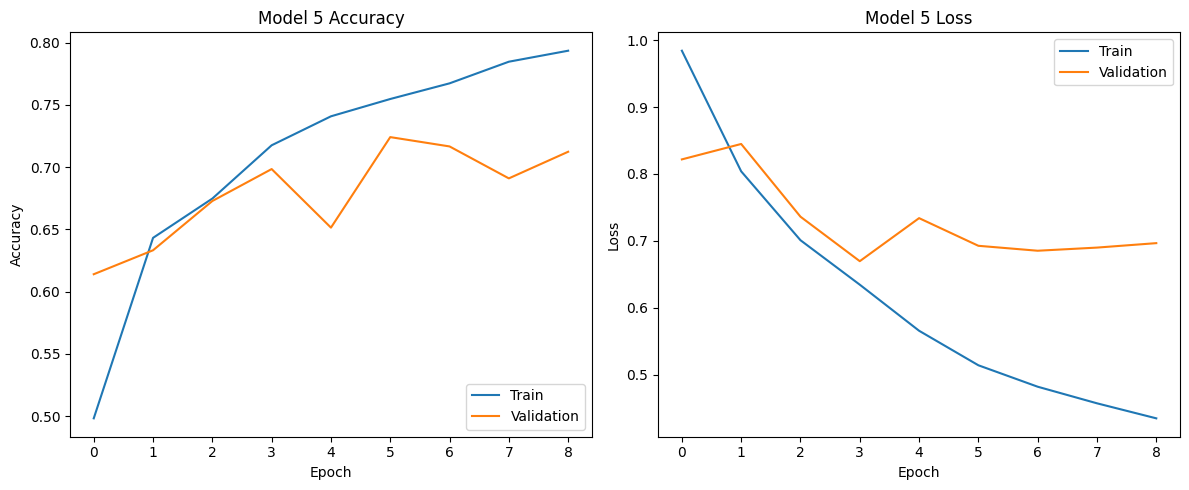

37/37 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.7194

Model 5 Test Loss: 0.6318
Model 5 Test Accuracy: 0.7194
37/37 [==============================] - 0s 3ms/step

Classification Report (Model 5 - LSTM with FFN Classifier head):
              precision    recall  f1-score   support

    negative       0.46      0.66      0.54       175
     neutral       0.85      0.70      0.77       622
    positive       0.71      0.77      0.74       372

    accuracy                           0.72      1169
   macro avg       0.68      0.71      0.69      1169
weighted avg       0.75      0.72      0.73      1169



In [21]:
# Build LSTM model with FFN classifier head
model5 = Sequential([
    # Embedding layer with pre-trained weights (non-trainable)
    Embedding(
        input_dim=len(vocabulary),
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=False
    ),
    # Stacked LSTMs
    LSTM(128, return_sequences=True),
    LSTM(64),
    # FFN classifier head
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("\nModel 5: LSTM with FFN Classifier head")
model5.summary()

# Train the model
history5 = model5.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model 5 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model 5 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('model5_history.png')
plt.show()

# Evaluate the model
loss5, accuracy5 = model5.evaluate(X_test, y_test)
print(f"\nModel 5 Test Loss: {loss5:.4f}")
print(f"Model 5 Test Accuracy: {accuracy5:.4f}")

# Get predictions and classification report
y_pred_prob5 = model5.predict(X_test)
y_pred5 = np.argmax(y_pred_prob5, axis=1)

# Print classification report
print("\nClassification Report (Model 5 - LSTM with FFN Classifier head):")
print(classification_report(y_true, y_pred5, target_names=['negative', 'neutral', 'positive']))

## 3.6- RNN using Bi-LSTMs with FFN Classifier head using pre-trained embeddings


Model 6: Bidirectional LSTM with FFN Classifier head
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 47, 300)           2328300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 47, 256)          439296    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 


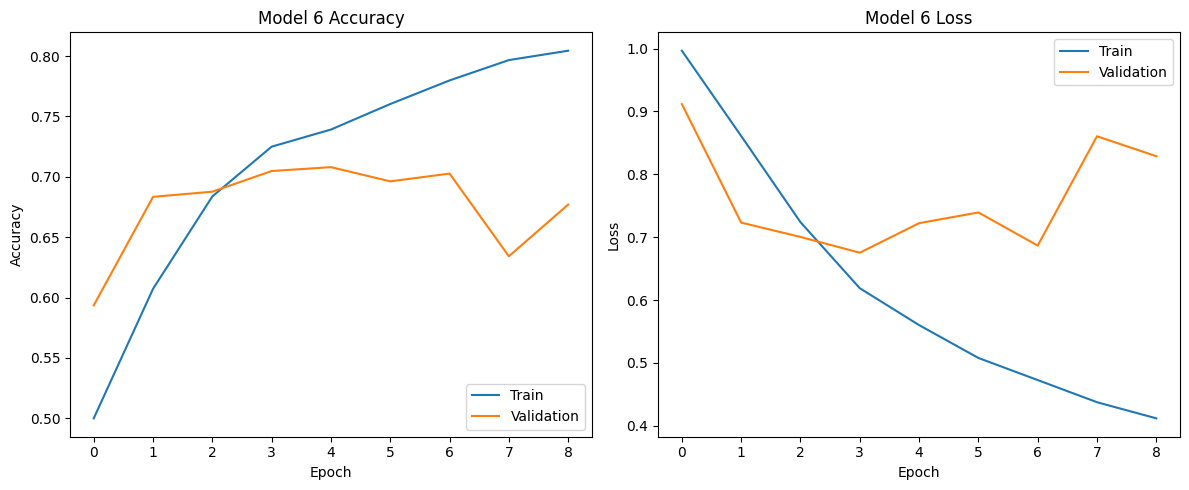

37/37 [==============================] - 0s 7ms/step - loss: 0.6518 - accuracy: 0.7271

Model 6 Test Loss: 0.6518
Model 6 Test Accuracy: 0.7271
37/37 [==============================] - 1s 6ms/step

Classification Report (Model 6 - Bidirectional LSTM with FFN Classifier head):
              precision    recall  f1-score   support

    negative       0.48      0.62      0.55       175
     neutral       0.82      0.76      0.79       622
    positive       0.73      0.72      0.73       372

    accuracy                           0.73      1169
   macro avg       0.68      0.70      0.69      1169
weighted avg       0.74      0.73      0.73      1169



In [22]:
# Build Bidirectional LSTM model with FFN classifier head
model6 = Sequential([
    # Embedding layer with pre-trained weights (non-trainable)
    Embedding(
        input_dim=len(vocabulary),
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=False
    ),
    # Bidirectional LSTMs
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    # FFN classifier head
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("\nModel 6: Bidirectional LSTM with FFN Classifier head")
model6.summary()

# Train the model
history6 = model6.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model 6 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model 6 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('model6_history.png')
plt.show()

# Evaluate the model
loss6, accuracy6 = model6.evaluate(X_test, y_test)
print(f"\nModel 6 Test Loss: {loss6:.4f}")
print(f"Model 6 Test Accuracy: {accuracy6:.4f}")

# Get predictions and classification report
y_pred_prob6 = model6.predict(X_test)
y_pred6 = np.argmax(y_pred_prob6, axis=1)

# Print classification report
print("\nClassification Report (Model 6 - Bidirectional LSTM with FFN Classifier head):")
print(classification_report(y_true, y_pred6, target_names=['negative', 'neutral', 'positive']))

## 3.7- Enhanced Bidirectional LSTM with Fine-tuned Embeddings



Model 7: Enhanced Bidirectional LSTM with Fine-tuned Embeddings
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 47, 300)           2328300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 47, 512)          1140736   
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 47, 512)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                       

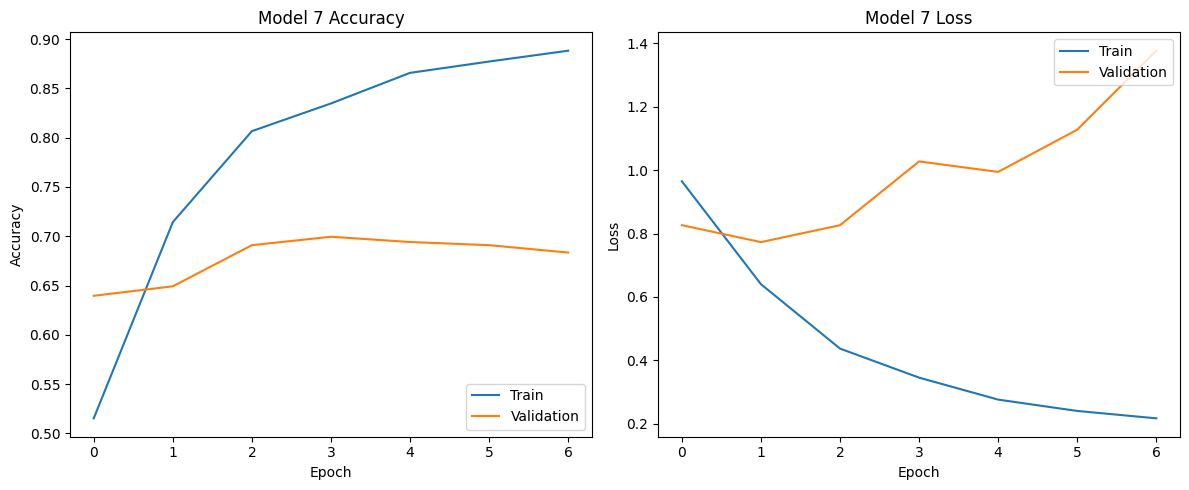

37/37 [==============================] - 0s 8ms/step - loss: 0.7139 - accuracy: 0.6681

Model 7 Test Loss: 0.7139
Model 7 Test Accuracy: 0.6681
37/37 [==============================] - 1s 8ms/step

Classification Report (Model 7 - Enhanced Bidirectional LSTM with Fine-tuned Embeddings):
              precision    recall  f1-score   support

    negative       0.38      0.79      0.51       175
     neutral       0.78      0.72      0.75       622
    positive       0.84      0.53      0.65       372

    accuracy                           0.67      1169
   macro avg       0.67      0.68      0.64      1169
weighted avg       0.74      0.67      0.68      1169



In [23]:
# Build a custom model based on previous results
model7 = Sequential([
    # Embedding layer with pre-trained weights (trainable)
    Embedding(
        input_dim=len(vocabulary),
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=True
    ),
    # Bidirectional LSTMs with increased capacity
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(128)),
    # Deeper FFN classifier head
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model with learning rate scheduling
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

model7.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("\nModel 7: Enhanced Bidirectional LSTM with Fine-tuned Embeddings")
model7.summary()

# Train the model
history7 = model7.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model 7 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model 7 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('model7_history.png')
plt.show()

# Evaluate the model
loss7, accuracy7 = model7.evaluate(X_test, y_test)
print(f"\nModel 7 Test Loss: {loss7:.4f}")
print(f"Model 7 Test Accuracy: {accuracy7:.4f}")

# Get predictions and classification report
y_pred_prob7 = model7.predict(X_test)
y_pred7 = np.argmax(y_pred_prob7, axis=1)

# Print classification report
print("\nClassification Report (Model 7 - Enhanced Bidirectional LSTM with Fine-tuned Embeddings):")
print(classification_report(y_true, y_pred7, target_names=['negative', 'neutral', 'positive']))

## Compare Model Performance

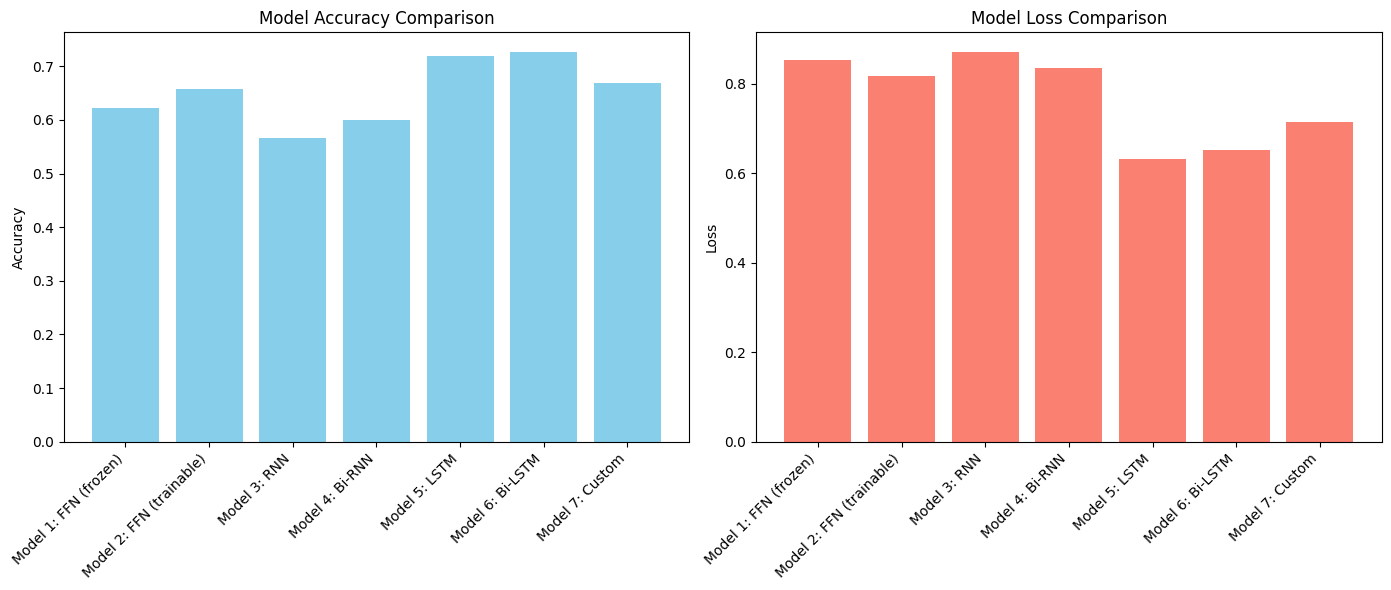


Model Performance Summary:
Model                          Accuracy   Loss      
------------------------------------------------------------
Model 1: FFN (frozen)          0.6228     0.8524
Model 2: FFN (trainable)       0.6587     0.8174
Model 3: RNN                   0.5672     0.8711
Model 4: Bi-RNN                0.6005     0.8348
Model 5: LSTM                  0.7194     0.6318
Model 6: Bi-LSTM               0.7271     0.6518
Model 7: Custom                0.6681     0.7139


In [24]:
# Compare all models' performance
models = ['Model 1: FFN (frozen)', 
          'Model 2: FFN (trainable)', 
          'Model 3: RNN', 
          'Model 4: Bi-RNN', 
          'Model 5: LSTM', 
          'Model 6: Bi-LSTM',
          'Model 7: Custom']

accuracies = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6, accuracy7]
losses = [loss1, loss2, loss3, loss4, loss5, loss6, loss7]

# Plot comparison
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.bar(models, losses, color='salmon')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Print summary of all models
print("\nModel Performance Summary:")
print("=" * 60)
print(f"{'Model':30} {'Accuracy':10} {'Loss':10}")
print("-" * 60)
for model_name, acc, loss in zip(models, accuracies, losses):
    print(f"{model_name:30} {acc:.4f}     {loss:.4f}")
print("=" * 60)